In [1]:
# -------------------------
# Imports
# -------------------------

import warnings, logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")
logging.getLogger("statsmodels").setLevel(logging.ERROR)

In [2]:
# -------------------------
# Config
# -------------------------

CSV    = "data_main.csv"
DATE   = "date"
TARGET = "log_total_dollar_volume"
EXOG   = "vix_close"

USE_LAGS = True     
MAX_LAGS  = 3

MAX_P = 5
MAX_Q = 5
MAX_D = 1

SPLITS = [
    dict(train_start=None,          train_end="2022-12-31", test_start="2023-01-01"),
    dict(train_start="2020-03-01",  train_end="2022-12-31", test_start="2023-01-01"),
]

# Define model families and their (p,d,q) grids
MODEL_SPECS = {
    "AR": dict(   p_grid=range(1, MAX_P+1), d_grid=[0,1],        q_grid=[0],        use_exog=False),
    "ARX": dict(  p_grid=range(1, MAX_P+1), d_grid=[0,1],        q_grid=[0],        use_exog=True),
    "MA": dict(   p_grid=[0],               d_grid=[0,1],        q_grid=range(1, MAX_Q+1), use_exog=False),
    "MAX": dict(  p_grid=[0],               d_grid=[0,1],        q_grid=range(1, MAX_Q+1), use_exog=True),
    "ARIMA": dict(p_grid=range(1, MAX_P+1), d_grid=range(0, MAX_D+1), q_grid=range(1, MAX_Q+1), use_exog=False),
    "ARIMAX": dict(p_grid=range(1, MAX_P+1), d_grid=range(0, MAX_D+1), q_grid=range(1, MAX_Q+1), use_exog=True),
}

In [3]:
# -------------------------
# Data
# -------------------------

df = pd.read_csv(CSV, parse_dates=[DATE]).set_index(DATE).sort_index()
df = df.asfreq("B").ffill()

y = df[TARGET].astype(float)
vix_full = df[EXOG].astype(float)

# Build exogenous X from VIX (standardized, optional lag)
if USE_LAGS:
    vix_feat = pd.DataFrame({
        f"vix_lag{L}": vix_full.shift(L)
        for L in range(1, MAX_LAGS + 1)
    })
else:
    vix_feat = vix_full.to_frame("vix")

def align_xy_dropna(y, X):
    y2, X2 = y.align(X, join="inner")
    mask = np.isfinite(y2.values) & np.isfinite(X2.values).all(axis=1)
    return y2[mask], X2[mask]

In [4]:
# -------------------------
# Parameter Estimation
# -------------------------

def aicc(res):
    k = res.params.size
    n = res.nobs
    return res.aic + (2*k*(k+1)) / max(n - k - 1, 1)

def fit_best_sarimax_train(y_train, X_train, p_grid, d_grid, q_grid, use_exog):
    
    if use_exog:
        y_train, X_train = align_xy_dropna(y_train, X_train)
    else:
        y_train = y_train.dropna().astype(float)
        X_train = None

    best_ic, best_order, best_res = np.inf, None, None

    for p in p_grid:
        for d in d_grid:
            for q in q_grid:
                if (p, d, q) == (0, 0, 0):
                    continue
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        m = SARIMAX(y_train,
                                    exog=X_train if use_exog else None,
                                    order=(p, d, q),
                                    enforce_stationarity=False
                                    )
                        r = m.fit(disp=False, method_kwargs={"disp": 0})
                    ic = aicc(r)
                    if ic < best_ic:
                        best_ic, best_order, best_res = ic, (p, d, q), r
                except Exception:
                    continue

    return best_order, best_ic, best_res


In [5]:
# -------------------------
# Forecast
# -------------------------

def forecast_and_score_1step_append(res_train, y_test, X_test=None, label=""):
    
    res_curr = res_train
    yhat_list = []

    for t in y_test.index:
        exog_t = None if X_test is None else X_test.loc[[t]]
        fc = res_curr.get_forecast(steps=1, exog=exog_t)
        yhat_t = float(fc.predicted_mean.iloc[0])
        yhat_list.append(yhat_t)

        res_curr = res_curr.append(endog=y_test.loc[[t]],
                                   exog=exog_t,
                                   refit=False)

    yhat = pd.Series(yhat_list, index=y_test.index)

    mae  = mean_absolute_error(y_test, yhat)
    rmse = np.sqrt(mean_squared_error(y_test, yhat))

    print(f"\n[{label}] 1-step-ahead test performance:")
    print(f"  MAE ={mae:.4f}, RMSE={rmse:.4f}")

    plt.figure(figsize=(12, 5))
    plt.plot(y_test, label="Actual", lw=1.5, color="black")
    plt.plot(yhat, label=f"{label} 1-step forecast", lw=1.5)
    plt.title(f"{label} — 1-step-ahead forecasts ({TARGET})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return dict(
        mae=mae,
        rmse=rmse,
        y_te=y_test,
        yhat=yhat,
    )

In [6]:
# -------------------------
# Residual Diagnostics
# -------------------------

def residual_diagnostics(res, name=""):
    resid_raw = pd.Series(res.resid).dropna()
    burn = getattr(res, "loglikelihood_burn", 0)
    resid = resid_raw.iloc[burn:]
    n = len(resid)

    p, d, q = res.model.order
    lags = max(5, min(20, int(10 * np.log10(n))))

    dw = durbin_watson(resid)
    lb = acorr_ljungbox(resid, lags=[lags], return_df=True, model_df=p+q)
    lb_stat, lb_p = float(lb["lb_stat"].iloc[-1]), float(lb["lb_pvalue"].iloc[-1])
    arch_stat, arch_p, _, _ = het_arch(resid, nlags=lags)
    jb_stat, jb_p, _, _ = jarque_bera(resid)

    print(f"\n[{name}] Residual diagnostics (train):")
    print(f"  Order (p,d,q): {p,d,q} | n_used={n} | burn={burn}")
    print(f"  Durbin–Watson           : {dw:.3f}  (≈2 ideal)")
    print(f"  Ljung–Box  (lag {lags}) : stat={lb_stat:.2f}, p={lb_p:.4g}")
    print(f"  ARCH test  (lag {lags}) : stat={arch_stat:.2f}, p={arch_p:.4g}")
    print(f"  Jarque–Bera             : stat={jb_stat:.2f}, p={jb_p:.4g}")

    return dict(dw=dw, lb_p=lb_p, arch_p=float(arch_p),
                jb_p=float(jb_p), lags=lags)


In [7]:
# -------------------------
# Function for running code
# -------------------------

def run_one_split(split_idx):
    sp = SPLITS[split_idx - 1]
    i = split_idx

    tr_start = sp["train_start"] or y.index.min().date()
    tr_end   = sp["train_end"]
    te_start = sp["test_start"]
    
    print(f"\n=== Split {i}: Train {tr_start} → {tr_end}, Test {te_start}")

    y_train = y.loc[:tr_end]
    
    if sp["train_start"]:
        y_train = y.loc[sp["train_start"]:tr_end]
    y_test  = y.loc[te_start:]

    X_train_raw = vix_feat.loc[y_train.index]
    X_test_raw  = vix_feat.loc[y_test.index]

    mu = X_train_raw.mean()
    sigma = X_train_raw.std(ddof=1).replace(0, 1)

    X_train_full = (X_train_raw - mu) / sigma
    X_test_full  = (X_test_raw  - mu) / sigma

    X_train_full.columns = [f"{c}_z" for c in X_train_full.columns]
    X_test_full.columns  = [f"{c}_z" for c in X_test_full.columns]

    for model_name, spec in MODEL_SPECS.items():
        print(f"\n--- Model: {model_name} (Split {i}) ---")
        use_exog = spec["use_exog"]

        X_train = X_train_full if use_exog else None
        X_test  = X_test_full  if use_exog else None

        order, ic, res_train = fit_best_sarimax_train(
            y_train, X_train,
            p_grid=spec["p_grid"],
            d_grid=spec["d_grid"],
            q_grid=spec["q_grid"],
            use_exog=use_exog
        )
        print(f"{model_name}: selected order {order}, AICc={ic:.2f}")

        diag = residual_diagnostics(res_train, name=f"{model_name}, Split {i}")

        scores = forecast_and_score_1step_append(
            res_train, y_test, X_test,
            label=f"{model_name}, Split {i}"
        )

        RESULTS[model_name].append({
            "split": f"Split {i}",
            "order": order,
            "train_len": len(y_train),
            "test_len": len(y_test),
            "AICc": ic,
            "DW": diag["dw"],
            "LB_p": diag["lb_p"],
            "ARCH_p": diag["arch_p"],
            "JB_p": diag["jb_p"],
            "MAE": scores["mae"],
            "RMSE": scores["rmse"],
            "scores": scores
        })


=== Split 1: Train 2004-01-02 → 2022-12-31, Test 2023-01-01

--- Model: AR (Split 1) ---
AR: selected order (5, 1, 0), AICc=-4025.00

[AR, Split 1] Residual diagnostics (train):
  Order (p,d,q): (5, 1, 0) | n_used=4950 | burn=6
  Durbin–Watson           : 2.002  (≈2 ideal)
  Ljung–Box  (lag 20) : stat=208.05, p=4.897e-36
  ARCH test  (lag 20) : stat=333.66, p=1.027e-58
  Jarque–Bera             : stat=12373.69, p=0

[AR, Split 1] 1-step-ahead test performance:
  MAE =0.1098, RMSE=0.1641


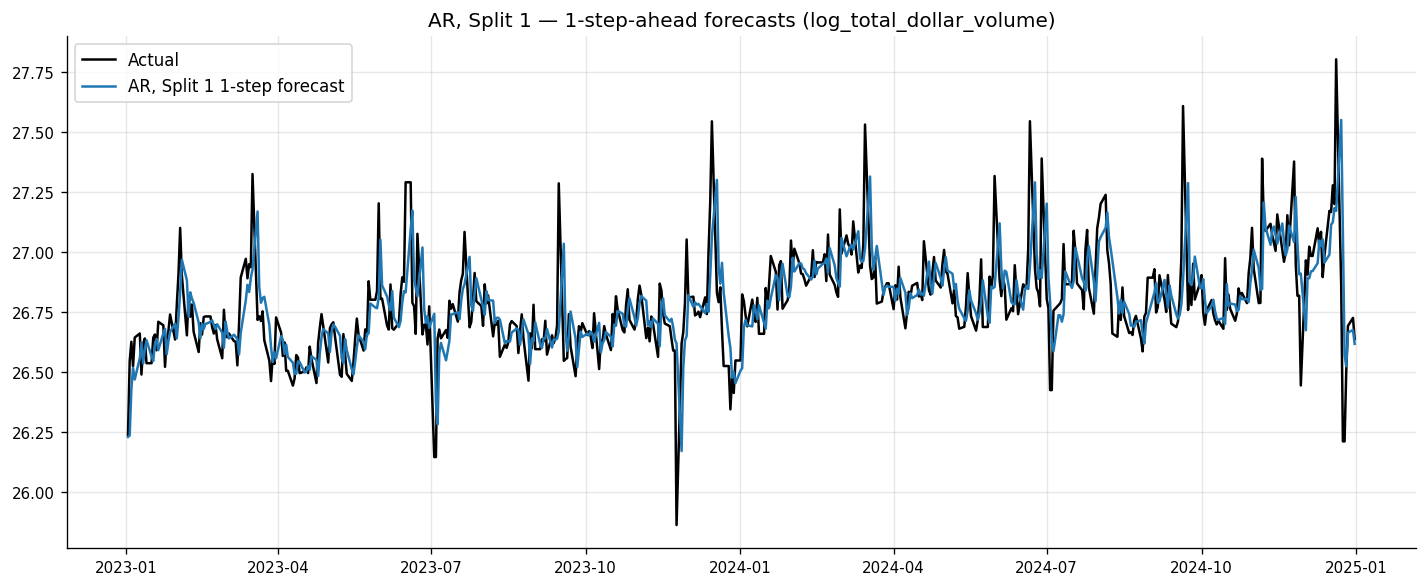


--- Model: ARX (Split 1) ---
ARX: selected order (5, 1, 0), AICc=-4062.81

[ARX, Split 1] Residual diagnostics (train):
  Order (p,d,q): (5, 1, 0) | n_used=4947 | burn=6
  Durbin–Watson           : 2.002  (≈2 ideal)
  Ljung–Box  (lag 20) : stat=206.66, p=9.378e-36
  ARCH test  (lag 20) : stat=329.50, p=7.345e-58
  Jarque–Bera             : stat=12405.71, p=0

[ARX, Split 1] 1-step-ahead test performance:
  MAE =0.1096, RMSE=0.1636


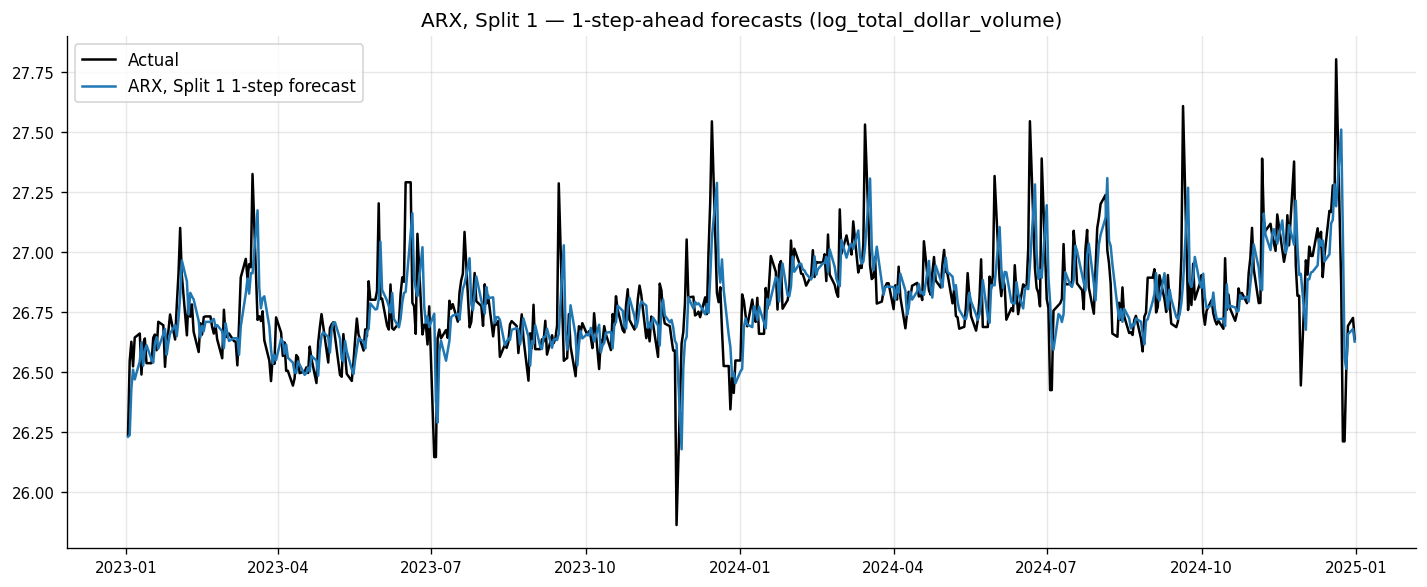


--- Model: MA (Split 1) ---
MA: selected order (0, 1, 5), AICc=-4194.45

[MA, Split 1] Residual diagnostics (train):
  Order (p,d,q): (0, 1, 5) | n_used=4949 | burn=7
  Durbin–Watson           : 1.994  (≈2 ideal)
  Ljung–Box  (lag 20) : stat=162.23, p=8.797e-27
  ARCH test  (lag 20) : stat=295.54, p=6.58e-51
  Jarque–Bera             : stat=12403.62, p=0

[MA, Split 1] 1-step-ahead test performance:
  MAE =0.1065, RMSE=0.1601


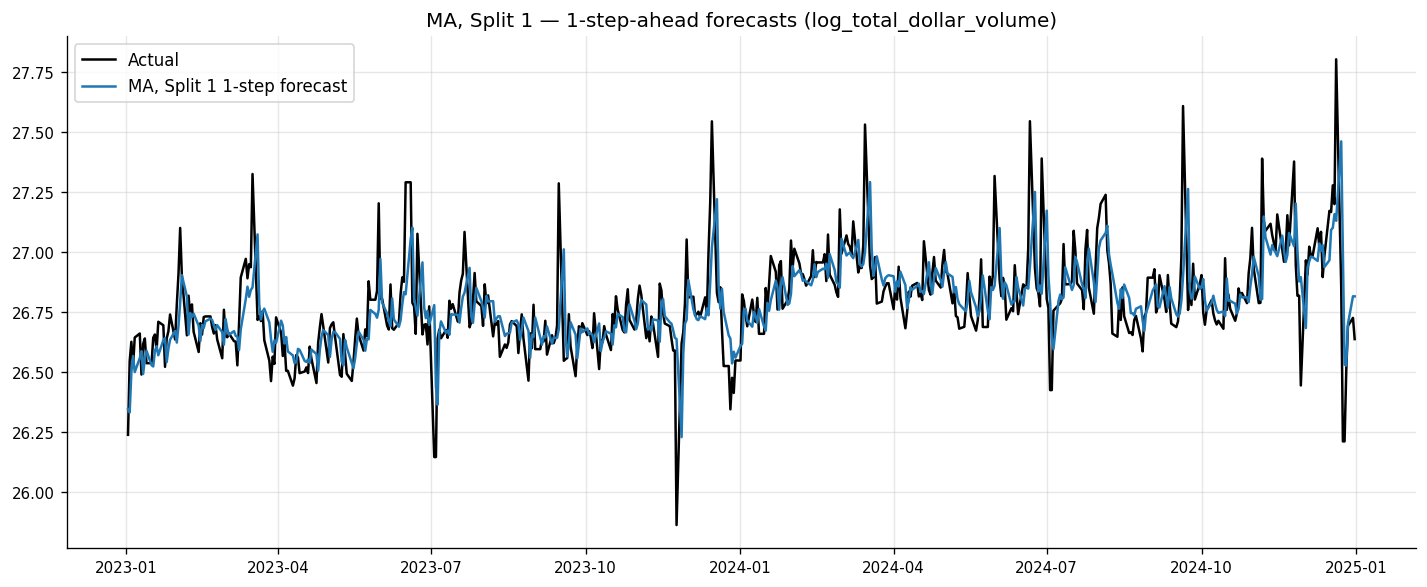


--- Model: MAX (Split 1) ---
MAX: selected order (0, 1, 5), AICc=-4242.06

[MAX, Split 1] Residual diagnostics (train):
  Order (p,d,q): (0, 1, 5) | n_used=4946 | burn=7
  Durbin–Watson           : 1.994  (≈2 ideal)
  Ljung–Box  (lag 20) : stat=160.31, p=2.136e-26
  ARCH test  (lag 20) : stat=284.85, p=9.912e-49
  Jarque–Bera             : stat=12408.94, p=0

[MAX, Split 1] 1-step-ahead test performance:
  MAE =0.1069, RMSE=0.1599


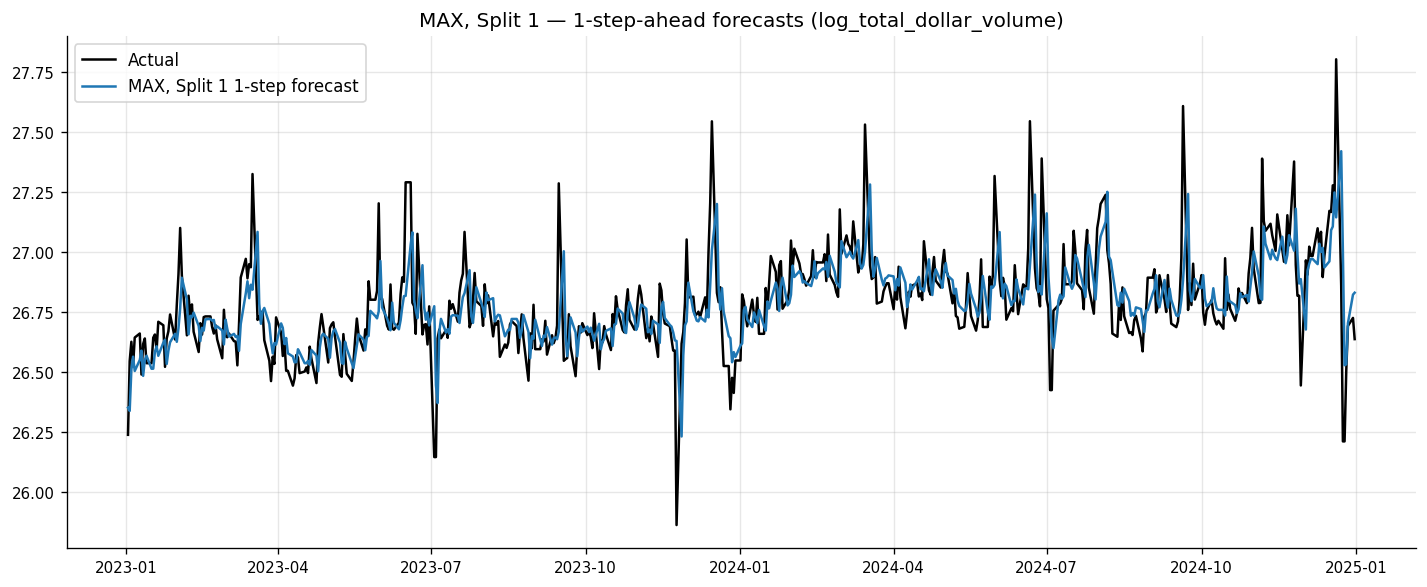


--- Model: ARIMA (Split 1) ---
ARIMA: selected order (4, 1, 4), AICc=-4402.26

[ARIMA, Split 1] Residual diagnostics (train):
  Order (p,d,q): (4, 1, 4) | n_used=4950 | burn=6
  Durbin–Watson           : 2.003  (≈2 ideal)
  Ljung–Box  (lag 20) : stat=71.03, p=2.056e-10
  ARCH test  (lag 20) : stat=386.75, p=1.138e-69
  Jarque–Bera             : stat=14663.82, p=0

[ARIMA, Split 1] 1-step-ahead test performance:
  MAE =0.1035, RMSE=0.1564


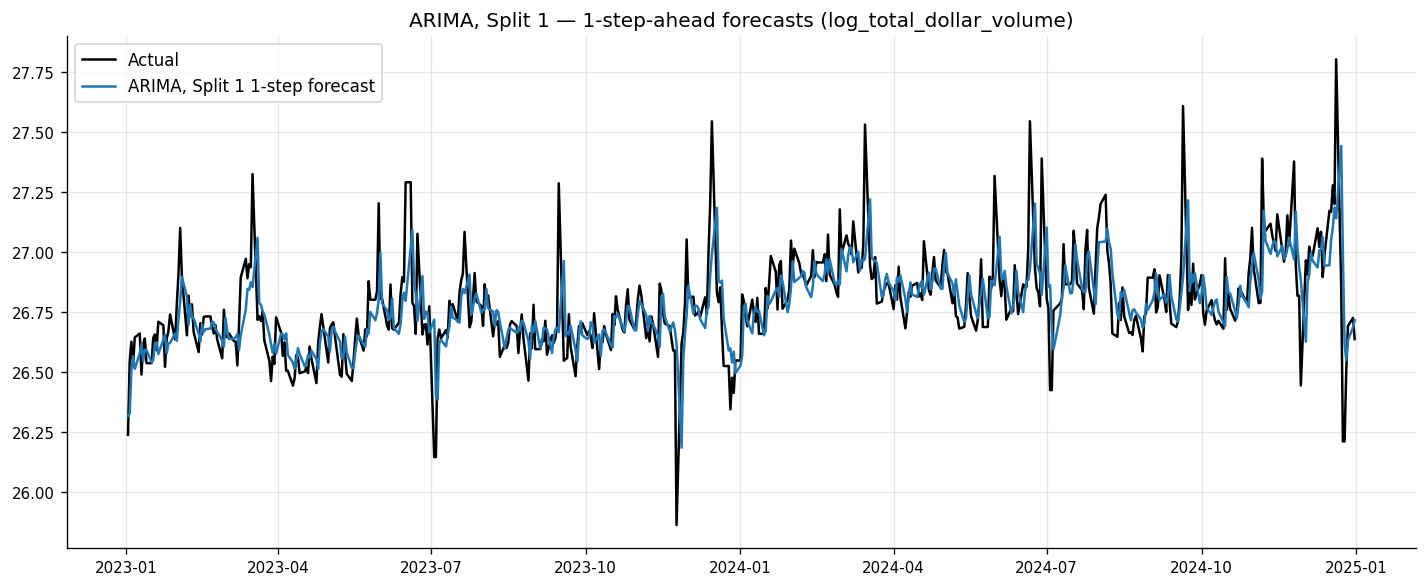


--- Model: ARIMAX (Split 1) ---
ARIMAX: selected order (5, 1, 5), AICc=-4455.10

[ARIMAX, Split 1] Residual diagnostics (train):
  Order (p,d,q): (5, 1, 5) | n_used=4946 | burn=7
  Durbin–Watson           : 1.992  (≈2 ideal)
  Ljung–Box  (lag 20) : stat=59.81, p=3.93e-09
  ARCH test  (lag 20) : stat=384.09, p=4.05e-69
  Jarque–Bera             : stat=15218.56, p=0

[ARIMAX, Split 1] 1-step-ahead test performance:
  MAE =0.1035, RMSE=0.1563


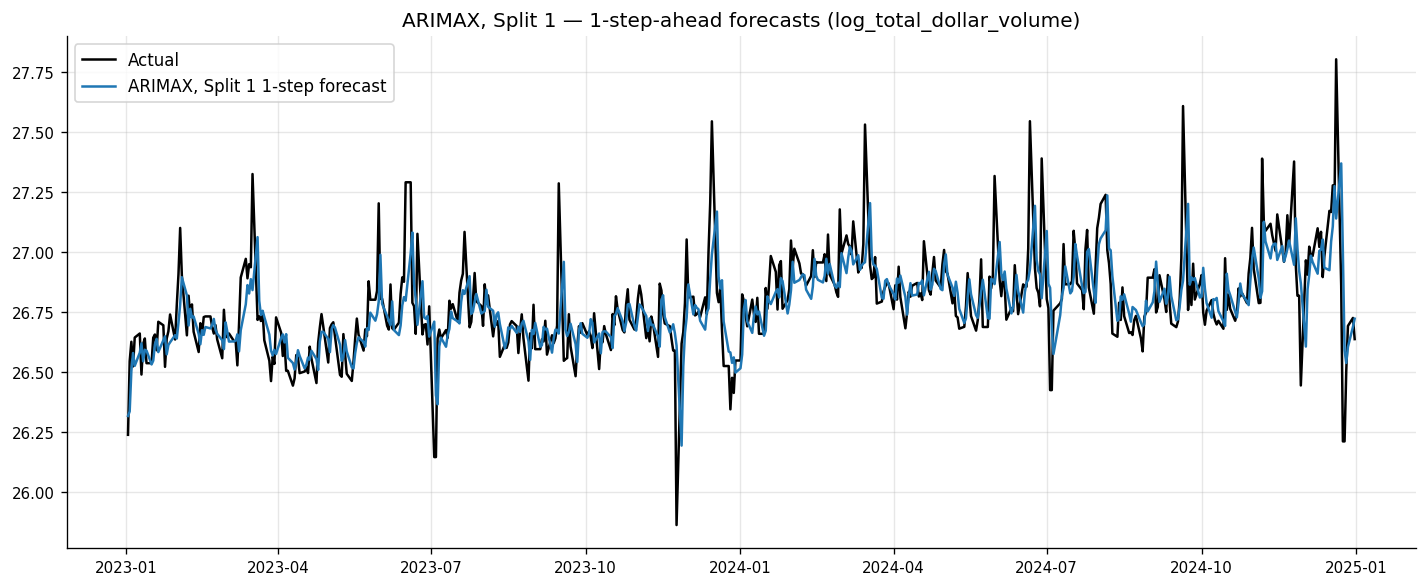

In [8]:
RESULTS = {name: [] for name in MODEL_SPECS}
run_one_split(1)


=== Split 2: Train 2020-03-01 → 2022-12-31, Test 2023-01-01

--- Model: AR (Split 2) ---
AR: selected order (5, 1, 0), AICc=-659.48

[AR, Split 2] Residual diagnostics (train):
  Order (p,d,q): (5, 1, 0) | n_used=734 | burn=6
  Durbin–Watson           : 2.018  (≈2 ideal)
  Ljung–Box  (lag 20) : stat=29.84, p=0.01251
  ARCH test  (lag 20) : stat=64.26, p=1.531e-06
  Jarque–Bera             : stat=580.59, p=8.422e-127

[AR, Split 2] 1-step-ahead test performance:
  MAE =0.1114, RMSE=0.1650


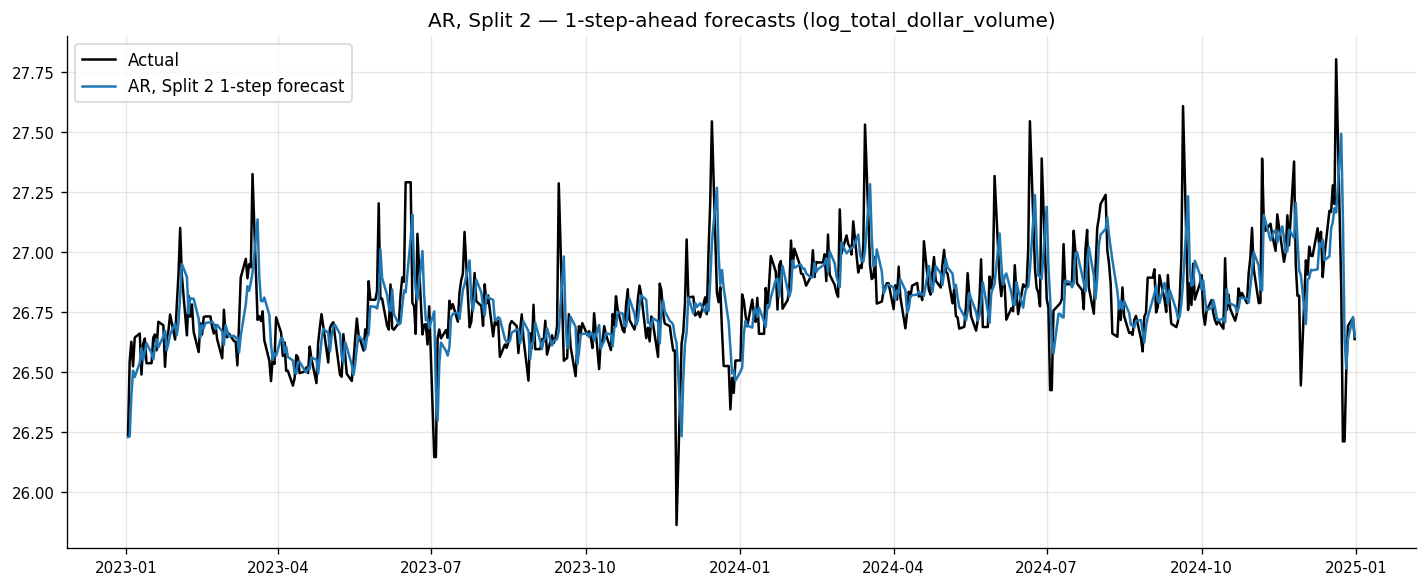


--- Model: ARX (Split 2) ---
ARX: selected order (5, 1, 0), AICc=-659.69

[ARX, Split 2] Residual diagnostics (train):
  Order (p,d,q): (5, 1, 0) | n_used=734 | burn=6
  Durbin–Watson           : 2.019  (≈2 ideal)
  Ljung–Box  (lag 20) : stat=29.68, p=0.01312
  ARCH test  (lag 20) : stat=61.56, p=4.075e-06
  Jarque–Bera             : stat=597.85, p=1.51e-130

[ARX, Split 2] 1-step-ahead test performance:
  MAE =0.1116, RMSE=0.1645


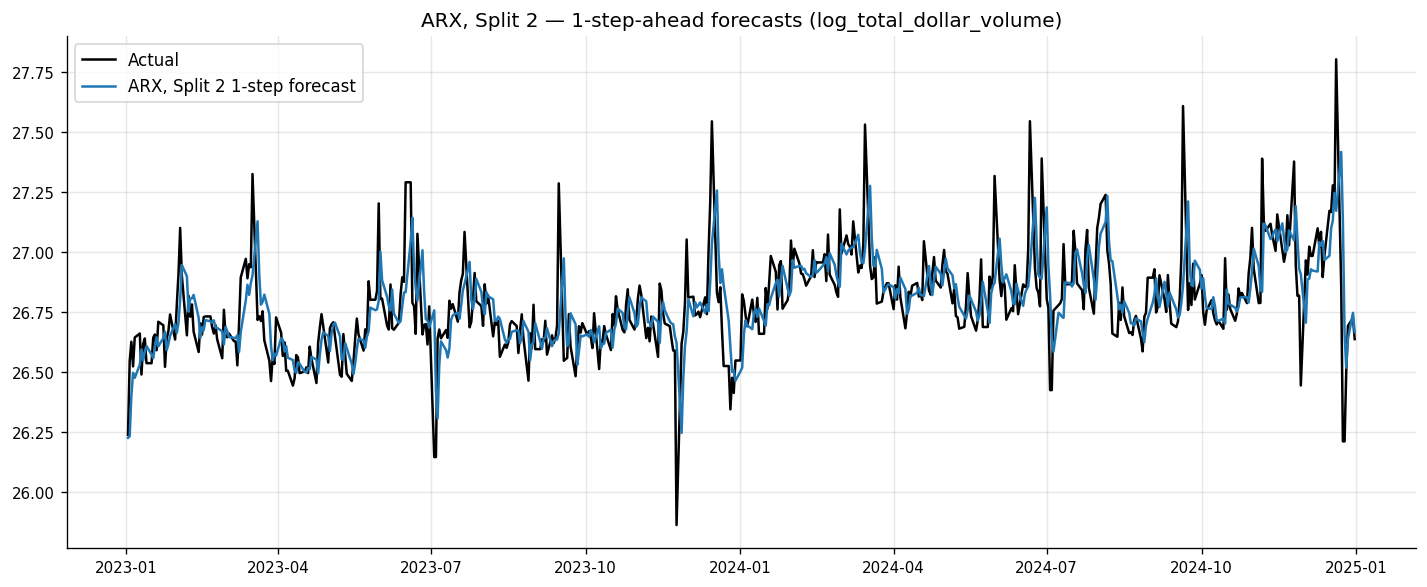


--- Model: MA (Split 2) ---
MA: selected order (0, 1, 4), AICc=-691.45

[MA, Split 2] Residual diagnostics (train):
  Order (p,d,q): (0, 1, 4) | n_used=734 | burn=6
  Durbin–Watson           : 1.992  (≈2 ideal)
  Ljung–Box  (lag 20) : stat=16.95, p=0.3887
  ARCH test  (lag 20) : stat=62.11, p=3.335e-06
  Jarque–Bera             : stat=655.23, p=5.225e-143

[MA, Split 2] 1-step-ahead test performance:
  MAE =0.1078, RMSE=0.1605


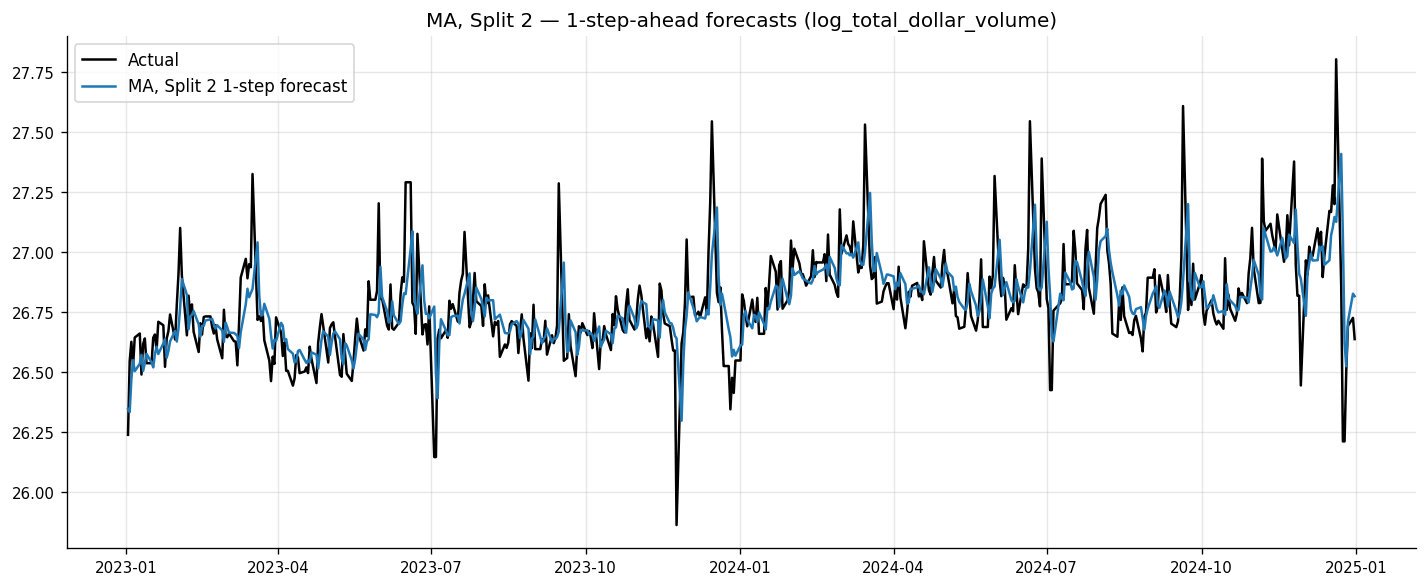


--- Model: MAX (Split 2) ---
MAX: selected order (0, 1, 4), AICc=-694.47

[MAX, Split 2] Residual diagnostics (train):
  Order (p,d,q): (0, 1, 4) | n_used=734 | burn=6
  Durbin–Watson           : 1.990  (≈2 ideal)
  Ljung–Box  (lag 20) : stat=15.54, p=0.4852
  ARCH test  (lag 20) : stat=59.15, p=9.617e-06
  Jarque–Bera             : stat=678.62, p=4.363e-148

[MAX, Split 2] 1-step-ahead test performance:
  MAE =0.1080, RMSE=0.1599


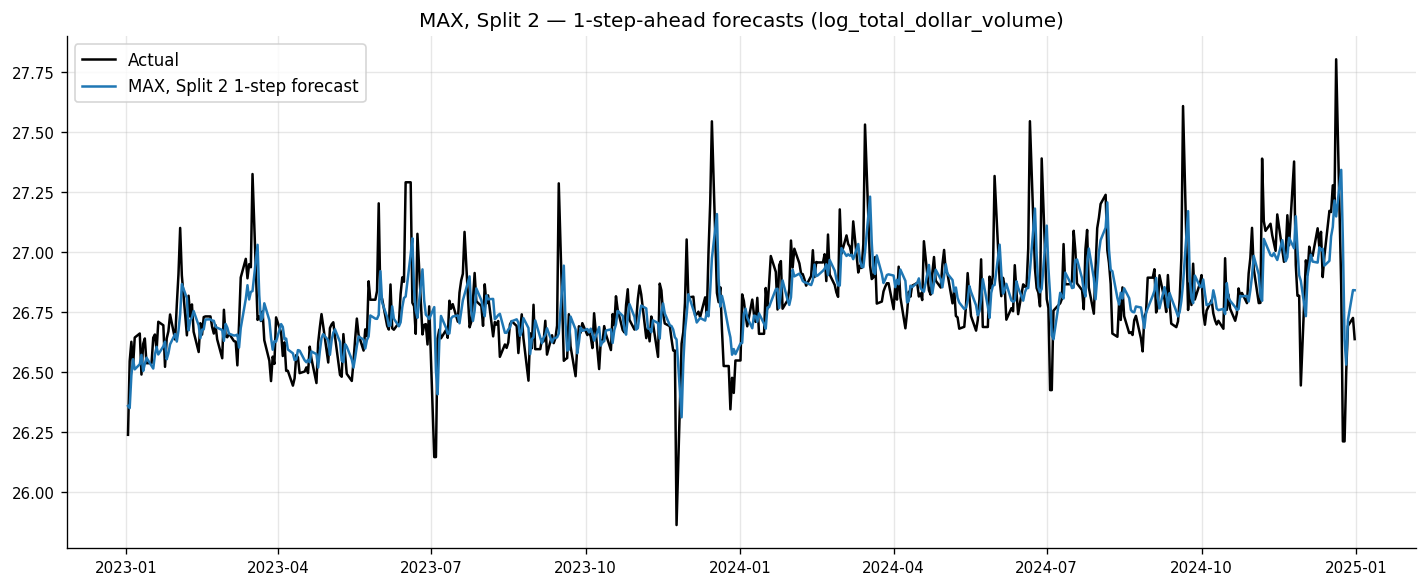


--- Model: ARIMA (Split 2) ---
ARIMA: selected order (2, 1, 1), AICc=-700.51

[ARIMA, Split 2] Residual diagnostics (train):
  Order (p,d,q): (2, 1, 1) | n_used=737 | burn=3
  Durbin–Watson           : 1.992  (≈2 ideal)
  Ljung–Box  (lag 20) : stat=12.99, p=0.737
  ARCH test  (lag 20) : stat=57.83, p=1.532e-05
  Jarque–Bera             : stat=680.77, p=1.485e-148

[ARIMA, Split 2] 1-step-ahead test performance:
  MAE =0.1068, RMSE=0.1595


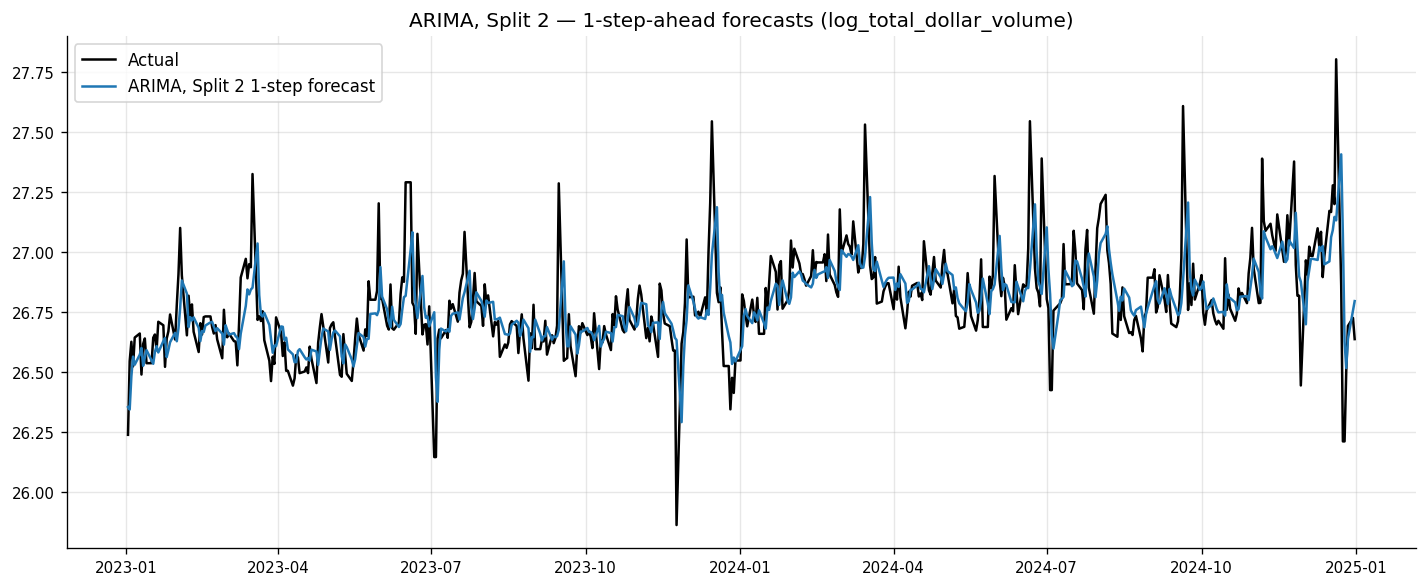


--- Model: ARIMAX (Split 2) ---
ARIMAX: selected order (2, 1, 1), AICc=-704.00

[ARIMAX, Split 2] Residual diagnostics (train):
  Order (p,d,q): (2, 1, 1) | n_used=737 | burn=3
  Durbin–Watson           : 1.993  (≈2 ideal)
  Ljung–Box  (lag 20) : stat=12.72, p=0.755
  ARCH test  (lag 20) : stat=55.86, p=3.056e-05
  Jarque–Bera             : stat=707.35, p=2.514e-154

[ARIMAX, Split 2] 1-step-ahead test performance:
  MAE =0.1070, RMSE=0.1590


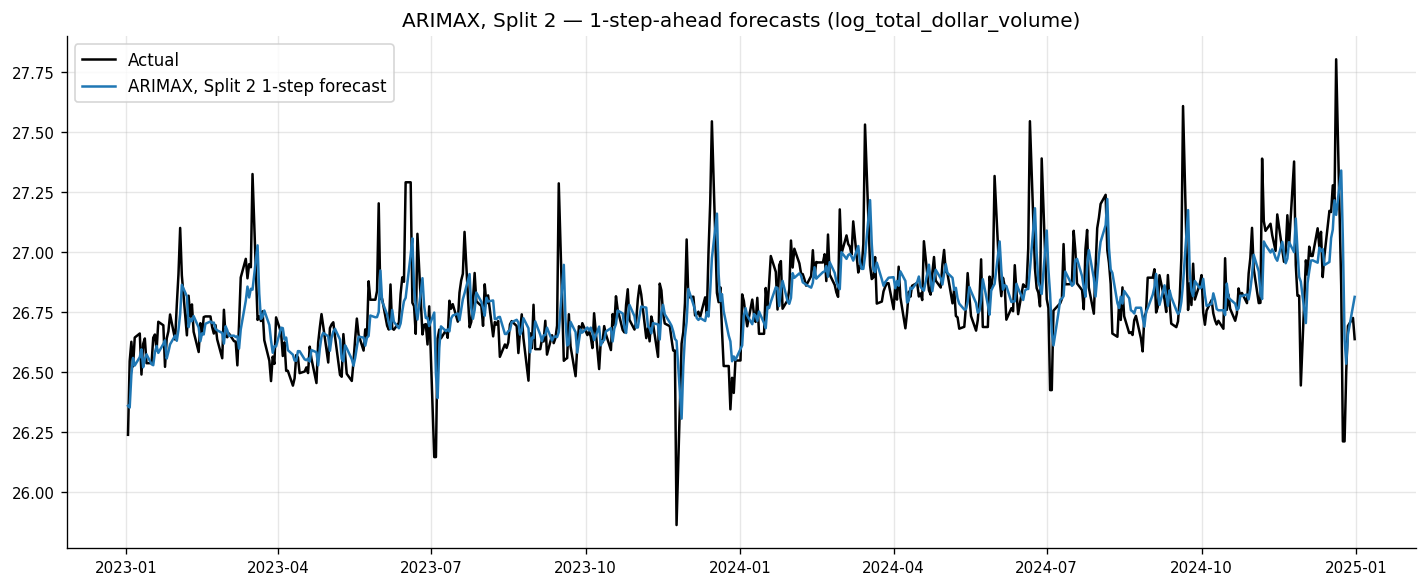

In [9]:
run_one_split(2)